In [1]:
import numpy as np
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
# 加载数据集
# data from https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary.html#a9a
X_train_orig,y_train_orig = load_svmlight_file('data/a9a')
X_val_orig, y_val_orig = load_svmlight_file('data/a9a.t', n_features=123)

# 转换为列向量
X_train = X_train_orig.T.toarray()
X_val = X_val_orig.T.toarray()
y_train = np.reshape(y_train_orig,(1,y_train_orig.shape[0]))
y_val = np.reshape(y_val_orig,(1,y_val_orig.shape[0]))
# y_train[y_train<0]=0
# y_val[y_val<0]=0
print(X_train.shape,X_val.shape,y_train.shape,y_val.shape)

(123, 32561) (123, 16281) (1, 32561) (1, 16281)


In [3]:
# 用零初始化参数
def init_parameters_with_zeros(dim):
    W = np.zeros((dim,1))
    b = 0
    return W,b

In [4]:
# 前向传播和反向传播
def propagate(C,W,b,X,Y):
    m = X.shape[1]

    # 前向传播
    A = np.dot(W.T,X)+b
    
    # 计算cost
    cost = np.sum(np.square(W))/2 + C*np.sum(np.maximum(0,1-Y*(np.dot(W.T,X)+b)))/m
    
    # 反向传播
    filt = (1-Y*(np.dot(W.T,X)+b))>0
    gW = W - C*np.dot(Y*filt,X.T).T/m
    gb = -C*np.sum(Y*filt*b)/m
    return cost,gW,gb

In [5]:
def predict(W,b,X):
    m = X.shape[1]
    A = np.dot(W.T,X)+b
    Y_prediction = np.zeros((1,m))
    Y_prediction[A>=0]=1
    Y_prediction[A<0]=-1
    return Y_prediction

In [6]:
def random_batches(X,Y,batch_size):
    m = X.shape[1]
    
    batches = []
    
    # 样本随机排列
    permutation = np.random.permutation(m)
    shuffled_X = X[:,permutation]
    shuffled_Y = Y[:,permutation]

    num_batches = math.floor(m/batch_size)
    for i in range(num_batches):
        batch_X = shuffled_X[:,i*batch_size:(i+1)*batch_size]
        batch_Y = shuffled_Y[:,i*batch_size:(i+1)*batch_size]
        
        batch = (batch_X, batch_Y)
        batches.append(batch)
    
    if m % batch_size != 0:
        batch_X = shuffled_X[:,num_batches*batch_size:m]
        batch_Y = shuffled_Y[:,num_batches*batch_size:m]
        batch = (batch_X, batch_Y)
        batches.append(batch)
    
    return batches
    

In [7]:
def model(X_train, Y_train, X_val, Y_val, C=0.9, batch_size = 64, num_epochs = 200, max_num_iterations = None, learning_rate = 0.01, optimizer = "GD", print_cost = False,
         decay_rate = 0.9):
    
    
    eps = 1e-8
    
    beta = 0.9
    
    W_cache = 0
    b_cache = 0
    
    delta_with_W = 0
    delta_with_b = 0
    delta_W = 0
    delta_b = 0
    
    beta1 = 0.9
    beta2 = 0.999
    vgW = 0
    sgW = 0
    vgb = 0
    sgb = 0
    
    # 保存训练集和验证集上的cost
    train_cost_log = []
    val_cost_log = []
    train_accuracy_log = []
    val_accuracy_log = []
    
    # 初始化参数
    W,b = init_parameters_with_zeros(X_train.shape[0])
    
    
    it = 0
    for i in range(num_epochs):
        if max_num_iterations and it>max_num_iterations:
            break
        batches = random_batches(X_train, Y_train, batch_size)
        
        # 计算验证集上的cost
#         val_cost,_,_= propagate(C,W,b,X_val,Y_val)
#         val_cost_log.append(val_cost)
        
        for batch in batches:
            it+=1
            if max_num_iterations and it>max_num_iterations:
                break
            (X_batch, Y_batch) = batch
            
    
            # 进行前向传播、反向传播，计算cost和梯度
            train_cost, gW, gb = propagate(C,W,b,X_batch,Y_batch)
            val_cost,_,_= propagate(C,W,b,X_val,Y_val)

            Y_batch_prediction = predict(W,b,X_batch)
            Y_val_prediction = predict(W,b,X_val)
#             train_accuracy = 100 - np.mean(np.abs(Y_batch_prediction - Y_batch) / 2) * 100
            val_accuracy = 100 - np.mean(np.abs(Y_val_prediction - Y_val) / 2) * 100

            # 保存cost
#             train_cost_log.append(train_cost)
            val_cost_log.append(val_cost)
#             train_accuracy_log.append(train_accuracy)
            val_accuracy_log.append(val_accuracy)

            # 更新参数
            if optimizer is "GD": # Gradient Descent
                W = W-learning_rate*gW
                b = b-learning_rate*gb
            elif optimizer is "NAG": # Nesterov Accelerated Gradient       
                vgW_prev = vgW
                vgW = beta * vgW - learning_rate * gW
                W = W - beta * vgW_prev + (1+beta) * vgW
                vgb_prev = vgb
                vgb = beta * vgb - learning_rate * gb
                b = b - beta * vgb_prev + (1+beta) * vgb
                
            elif optimizer is "RMSProp": # RMSProp
                W_cache = decay_rate * W_cache + (1 - decay_rate) * gW**2
                W = W - learning_rate * gW / (np.sqrt(W_cache) + eps)
                b_cache = decay_rate * b_cache + (1 - decay_rate) * gb**2
                b = b - learning_rate * gb / (np.sqrt(b_cache) + eps)

            elif optimizer is "AdaDelta": # AdaDelta
                W_cache = beta * W_cache + (1-beta) * gW**2
                delta_W =  - np.sqrt(delta_with_W + eps)/(np.sqrt(W_cache)+eps) * gW
                W = W + delta_W
                delta_with_W = beta * delta_with_W + (1-beta)* delta_W ** 2
                
                b_cache = beta * b_cache + (1-beta) * gb**2
                delta_b =  - np.sqrt(delta_with_b + eps)/(np.sqrt(b_cache)+eps) * gb
                b = b + delta_b
                delta_with_b = beta * delta_with_b + (1-beta)* delta_b ** 2
                
            elif optimizer is "Adam": # Adam
                vgW = beta1*vgW + (1-beta1)*gW
                sgW = beta2*sgW + (1-beta2)*(gW**2)
                W = W - learning_rate * vgW / (np.sqrt(sgW) + eps)
                vgb = beta1*vgb + (1-beta1)*gb
                sgb = beta2*sgb + (1-beta2)*(gb**2)
                b = b - learning_rate * vgb / (np.sqrt(sgb) + eps)

        
        if print_cost and i % 10 == 0:
            print ("After epoch %i, train cost: %f" %(i, train_cost))

    
    return W,b,train_cost_log,val_cost_log,train_accuracy_log,val_accuracy_log

In [8]:
num_epochs = 60
batch_size = 4096
_,_,_,loss_NAG,_,accuracy_NAG = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,batch_size=batch_size ,learning_rate = 0.001,optimizer = 'NAG',print_cost=True)
_,_,_,loss_RMSProp,_,accuracy_RMSProp = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,batch_size=batch_size ,learning_rate = 0.001,optimizer = 'RMSProp',print_cost=True)
_,_,_,loss_AdaDelta,_,accuracy_AdaDelta = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,batch_size=batch_size ,learning_rate = 0.001,optimizer = 'AdaDelta',print_cost=True)
_,_,_,loss_Adam,_,accuracy_Adam = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,batch_size=batch_size ,learning_rate = 0.001,optimizer = 'Adam',print_cost=True)
_,_,_,loss_GD,_,accuracy_GD = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,batch_size=batch_size ,learning_rate = 0.001,optimizer = 'GD',print_cost=True)

After epoch 0, train cost: 0.858930
After epoch 10, train cost: 0.528564
After epoch 20, train cost: 0.534731
After epoch 30, train cost: 0.526424
After epoch 40, train cost: 0.499723
After epoch 50, train cost: 0.516796
After epoch 0, train cost: 0.814895
After epoch 10, train cost: 0.552748
After epoch 20, train cost: 0.505450
After epoch 30, train cost: 0.521492
After epoch 40, train cost: 0.504647
After epoch 50, train cost: 0.509354
After epoch 0, train cost: 0.885363
After epoch 10, train cost: 0.724480
After epoch 20, train cost: 0.582475
After epoch 30, train cost: 0.558272
After epoch 40, train cost: 0.512639
After epoch 50, train cost: 0.507626
After epoch 0, train cost: 0.700935
After epoch 10, train cost: 0.521750
After epoch 20, train cost: 0.517500
After epoch 30, train cost: 0.537690
After epoch 40, train cost: 0.516844
After epoch 50, train cost: 0.538537
After epoch 0, train cost: 0.889607
After epoch 10, train cost: 0.780280
After epoch 20, train cost: 0.690526
After 

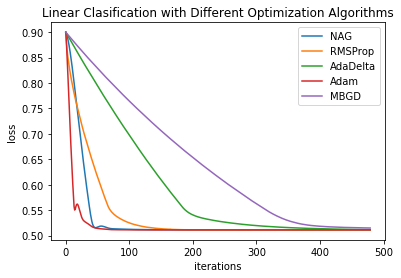

In [9]:
# 画图
plt.plot(loss_NAG, label='NAG')
plt.plot(loss_RMSProp, label='RMSProp')
plt.plot(loss_AdaDelta, label='AdaDelta')
plt.plot(loss_Adam, label='Adam')
plt.plot(loss_GD, label='MBGD')


plt.legend() # 图例
# plt.axis([0,20,300,600])
plt.ylabel('loss')
plt.xlabel('iterations')
# plt.yscale('log')
plt.title('Linear Clasification with Different Optimization Algorithms')
# plt.show()
plt.savefig('report/linear_classification_loss_with_different_optimization_algorithm.eps', format='eps', dpi=1000)

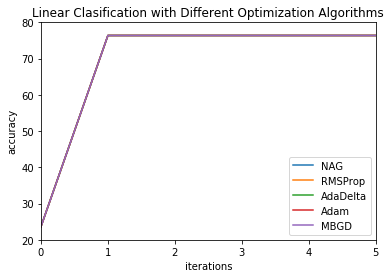

In [10]:
# 画图
plt.plot(accuracy_NAG, label='NAG')
plt.plot(accuracy_RMSProp, label='RMSProp')
plt.plot(accuracy_AdaDelta, label='AdaDelta')
plt.plot(accuracy_Adam, label='Adam')
plt.plot(accuracy_GD, label='MBGD')


plt.legend() # 图例
plt.axis([0,5,20,80])
plt.ylabel('accuracy')
plt.xlabel('iterations')
# plt.yscale('log')
plt.title('Linear Clasification with Different Optimization Algorithms')
# plt.show()
plt.savefig('report/linear_classification_accuracy_with_different_optimization_algorithm.eps', format='eps', dpi=1000)

In [11]:
num_epochs = 800
max_num_iterations = 200
_,_,_,loss_batch_size_1,_,accuracy_batch_size_1 = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,max_num_iterations = max_num_iterations,batch_size=1 ,learning_rate = 0.01,optimizer = 'GD',print_cost=True)
_,_,_,loss_batch_size_2,_,accuracy_batch_size_2 = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,max_num_iterations = max_num_iterations,batch_size=2 ,learning_rate = 0.01,optimizer = 'GD',print_cost=True)
_,_,_,loss_batch_size_4,_,accuracy_batch_size_4 = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,max_num_iterations = max_num_iterations,batch_size=4 ,learning_rate = 0.01,optimizer = 'GD',print_cost=True)
_,_,_,loss_batch_size_8,_,accuracy_batch_size_8 = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,max_num_iterations = max_num_iterations,batch_size=8 ,learning_rate = 0.01,optimizer = 'GD',print_cost=True)
# _,_,_,loss_batch_size_16,_,accuracy_batch_size_16 = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,max_num_iterations = max_num_iterations,batch_size=16 ,learning_rate = 0.01,optimizer = 'GD',print_cost=True)
# _,_,_,loss_batch_size_256,_,accuracy_batch_size_256 = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,max_num_iterations = max_num_iterations,batch_size=256,learning_rate = 0.01,optimizer = 'GD',print_cost=True)
# _,_,_,loss_batch_size_4096,_,accuracy_batch_size_4096 = model(X_train,y_train,X_val,y_val,num_epochs = num_epochs,max_num_iterations = max_num_iterations,batch_size=4096 ,learning_rate = 0.01,optimizer = 'GD',print_cost=True)

After epoch 0, train cost: 0.106518
After epoch 0, train cost: 0.989790
After epoch 0, train cost: 0.947636
After epoch 0, train cost: 0.560046


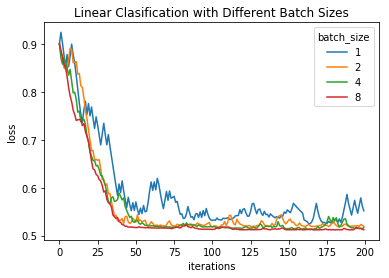

In [12]:
plt.plot(loss_batch_size_1, label='1')
plt.plot(loss_batch_size_2, label='2')
plt.plot(loss_batch_size_4 , label='4')
plt.plot(loss_batch_size_8, label='8')
# plt.plot(loss_batch_size_16, label='16')
# plt.plot(loss_batch_size_256, label='256')
# plt.plot(loss_batch_size_4096, label='4096')
# plt.plot(GD_loss, label='MGD')
# plt.plot(val_loss_log,'b', label = 'validation set')


plt.legend(title='batch_size') # 图例
# plt.axis([0,200,0.5,0.9])
plt.ylabel('loss')
plt.xlabel('iterations')
# plt.yscale('log')
plt.title('Linear Clasification with Different Batch Sizes')
# plt.show()
plt.savefig('report/linear_classification_loss_with_different_batch_size.eps', format='eps', dpi=1000)

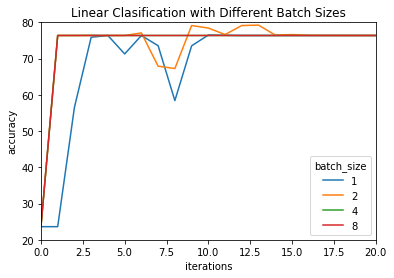

In [13]:
plt.plot(accuracy_batch_size_1, label='1')
plt.plot(accuracy_batch_size_2, label='2')
plt.plot(accuracy_batch_size_4 , label='4')
plt.plot(accuracy_batch_size_8, label='8')
# plt.plot(loss_batch_size_16, label='16')
# plt.plot(loss_batch_size_256, label='256')
# plt.plot(loss_batch_size_4096, label='4096')
# plt.plot(GD_loss, label='MGD')
# plt.plot(val_loss_log,'b', label = 'validation set')


plt.legend(title='batch_size') # 图例
plt.axis([0,20,20,80])
plt.ylabel('accuracy')
plt.xlabel('iterations')
# plt.yscale('log')
plt.title('Linear Clasification with Different Batch Sizes')
# plt.show()
plt.savefig('report/linear_classification_accuracy_with_different_batch_size.eps', format='eps', dpi=1000)